In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn 

# Define transformations and load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Optionally use a smaller subset for faster training
train_dataset_small = torch.utils.data.Subset(train_dataset, np.arange(5000))  # Take first 5000 images

# DataLoader
train_loader = DataLoader(train_dataset_small, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
from torchvision.models import googlenet, GoogLeNet_Weights

# Load model with default weights
weights = GoogLeNet_Weights.DEFAULT
model = googlenet(weights=weights)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [16]:
import torch
import torch.nn as nn
from torchvision import models

# Define GoogLeNet embedding network
class GoogLeNetEmbeddingNet(nn.Module):
    def __init__(self):
        super(GoogLeNetEmbeddingNet, self).__init__()
        self.googlenet = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        # Replace the final fully connected layer to output 1024-dimensional embeddings
        self.googlenet.fc = nn.Linear(1024, 1024)  # Embedding layer, not classification

    def forward(self, x):
        x = self.googlenet(x)
        return x

# Initialize the embedding network
embedding_net = GoogLeNetEmbeddingNet().cuda() if torch.cuda.is_available() else GoogLeNetEmbeddingNet()


In [17]:
import torch.optim as optim

# Modify the fully connected layer to classify CIFAR-10 (10 classes)
embedding_net.googlenet.fc = nn.Linear(1024, 10)  # Classification layer for CIFAR-10

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(embedding_net.parameters(), lr=0.001)

# Training loop for classification
for epoch in range(20):  # Train for 20 epochs
    embedding_net.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.cuda() if torch.cuda.is_available() else images
        labels = labels.cuda() if torch.cuda.is_available() else labels

        outputs = embedding_net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# After pretraining, switch back to embedding output
embedding_net.googlenet.fc = nn.Linear(1024, 1024)  # Switch back to embedding output


Epoch 1, Loss: 0.9655409762813787
Epoch 2, Loss: 0.6281901821968662
Epoch 3, Loss: 0.46406564600528427
Epoch 4, Loss: 0.3573943038654935
Epoch 5, Loss: 0.2956982884010312
Epoch 6, Loss: 0.253455770931616
Epoch 7, Loss: 0.17011649568511802
Epoch 8, Loss: 0.1458517807079064
Epoch 9, Loss: 0.20261574518172795
Epoch 10, Loss: 0.18333279608992065
Epoch 11, Loss: 0.09849190691806328
Epoch 12, Loss: 0.07475077274854586
Epoch 13, Loss: 0.08506595317547204
Epoch 14, Loss: 0.13699625739471832
Epoch 15, Loss: 0.17154447146495627
Epoch 16, Loss: 0.12109975554464254
Epoch 17, Loss: 0.09958819500140988
Epoch 18, Loss: 0.05614719666973658
Epoch 19, Loss: 0.09598089690960848
Epoch 20, Loss: 0.050448330787342684


In [18]:
import torch.nn.functional as F

class MagnetLoss(nn.Module):
    def __init__(self, alpha=3.0):
        super(MagnetLoss, self).__init__()
        self.alpha = alpha

    def forward(self, r, classes, m, d, alpha=1.0):
        epsilon = 1e-8  # Small value for numerical stability

        self.r = r
        self.classes = torch.from_numpy(classes).type(torch.LongTensor).to(r.device)
        self.clusters, _ = torch.sort(torch.arange(0, float(m)).repeat(d).to(r.device))  # Repeat d times
        self.cluster_classes = self.classes[0:m*d:d]  # Use m * d sized labels
        self.n_clusters = m
        self.alpha = alpha

        # Take cluster means within the batch
        cluster_examples = dynamic_partition(self.r, self.clusters, self.n_clusters)
        cluster_means = torch.stack([torch.mean(x, dim=0) for x in cluster_examples])

        # Compute sample costs (distances)
        sample_costs = compute_euclidean_distance(cluster_means, expand_dims(r, 1))
        clusters_tensor = self.clusters.type(torch.FloatTensor).to(r.device)
        n_clusters_tensor = torch.arange(0, self.n_clusters).type(torch.FloatTensor).to(r.device)

        intra_cluster_mask = comparison_mask(clusters_tensor, n_clusters_tensor).type(torch.FloatTensor)
        intra_cluster_costs = torch.sum(intra_cluster_mask * sample_costs, dim=1)

        N = r.size()[0]
        variance = torch.sum(intra_cluster_costs) / float(N - 1)
        variance = torch.clamp(variance, min=epsilon)  # Avoid zero or negative variance

        var_normalizer = -1 / (2 * variance**2)

        # Compute numerator and denominator
        numerator = torch.exp(var_normalizer * intra_cluster_costs - self.alpha)
        numerator = torch.clamp(numerator, min=epsilon, max=1e8)

        classes_tensor = self.classes.type(torch.FloatTensor).to(r.device)
        cluster_classes_tensor = self.cluster_classes.type(torch.FloatTensor).to(r.device)

        diff_class_mask = comparison_mask(classes_tensor, cluster_classes_tensor).type(torch.FloatTensor)
        diff_class_mask = 1 - diff_class_mask  # Logical not on ByteTensor

        denom_sample_costs = torch.exp(var_normalizer * sample_costs)
        denominator = torch.sum(diff_class_mask * denom_sample_costs, dim=1)
        denominator = torch.clamp(denominator, min=epsilon, max=1e8)

        # Compute loss
        losses = F.relu(-torch.log(numerator / (denominator + epsilon) + epsilon))
        total_loss = torch.mean(losses)

        return total_loss, losses

# Helper functions
def expand_dims(var, dim=0):
    sizes = list(var.size())
    sizes.insert(dim, 1)
    return var.view(*sizes)

def comparison_mask(a_labels, b_labels):
    return torch.eq(expand_dims(a_labels, 1), expand_dims(b_labels, 0))

def dynamic_partition(X, partitions, n_clusters):
    cluster_bin = torch.chunk(X, n_clusters)
    return cluster_bin

def compute_euclidean_distance(x, y):
    return torch.sum((x - y)**2, dim=2)


In [19]:
import torch.optim as optim

optimizer = optim.Adam(embedding_net.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
magnet_loss = MagnetLoss(alpha=0.5)
num_epochs = 50

embedding_net = embedding_net.cuda() if torch.cuda.is_available() else embedding_net

for epoch in range(num_epochs):
    embedding_net.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.cuda() if torch.cuda.is_available() else images
        embeddings = embedding_net(images)
        
        embeddings_np = embeddings.cpu().detach().numpy()
        labels_np = labels.cpu().numpy()

        batch_size = embeddings.size(0)
        m = min(12, batch_size)
        d = batch_size // m
        effective_batch_size = m * d
        
        embeddings = embeddings[:effective_batch_size]
        labels_trimmed = labels_np[:effective_batch_size]

        # Compute the Magnet Loss
        loss, _ = magnet_loss(embeddings, labels_trimmed, m=m, d=d, alpha=0.5)
        
        if torch.isnan(loss):
            print('NaN detected, skipping this batch.')
            continue
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(embedding_net.parameters(), max_norm=5.0)
        optimizer.step()
        
        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


Epoch [1/50], Loss: 2.748275683943633
Epoch [2/50], Loss: 2.274701567402311
Epoch [3/50], Loss: 0.2618916514952471
Epoch [4/50], Loss: 0.24658019888173244
Epoch [5/50], Loss: 0.22850890210859334
Epoch [6/50], Loss: 0.22279246654480125
Epoch [7/50], Loss: 0.2252142367659101
Epoch [8/50], Loss: 0.2264851060262911
Epoch [9/50], Loss: 0.22439802120065994
Epoch [10/50], Loss: 0.22385272706390186
Epoch [11/50], Loss: 0.22439606430803893
Epoch [12/50], Loss: 0.22591777715333708
Epoch [13/50], Loss: 0.22916168107348642
Epoch [14/50], Loss: 0.22571047219880827
Epoch [15/50], Loss: 0.2244982404314029
Epoch [16/50], Loss: 0.22118954702167754
Epoch [17/50], Loss: 0.2198435319646908
Epoch [18/50], Loss: 0.22377423809212485
Epoch [19/50], Loss: 0.22404213904575176
Epoch [20/50], Loss: 0.22367475926876068
Epoch [21/50], Loss: 0.22479827721027812
Epoch [22/50], Loss: 0.2195113052608101
Epoch [23/50], Loss: 0.22518346501383812
Epoch [24/50], Loss: 0.2240848658001347
Epoch [25/50], Loss: 0.2251840486268

In [28]:
from sklearn.cluster import KMeans
import torch

# K-means clustering for clusters in embedding space
def compute_cluster_means(embeddings, labels, m):
    cluster_means = []
    unique_labels = np.unique(labels)
    
    # Ensure embeddings are a NumPy array for KMeans compatibility
    if torch.is_tensor(embeddings):
        embeddings = embeddings.cpu().detach().numpy()
    
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_embeddings = embeddings[label_indices]
        
        # If the number of samples is less than m, reduce m
        n_samples = len(label_indices)
        clusters = min(m, n_samples)  # Adjust number of clusters based on available samples
        
        if clusters > 1:  # Apply K-means only if more than one cluster can be formed
            kmeans = KMeans(n_clusters=clusters)
            kmeans.fit(label_embeddings)
            cluster_means.append(kmeans.cluster_centers_)
        else:  # If we can't apply K-means (only one sample), treat the sample as the cluster center
            cluster_means.append(label_embeddings)

    # Concatenate the cluster means and return them as a torch tensor
    if len(cluster_means) > 0:
        cluster_means = np.concatenate(cluster_means, axis=0)
    else:
        cluster_means = np.zeros((0, embeddings.shape[1]))

    # Convert cluster means to a PyTorch tensor and ensure it's on the same device as embeddings
    cluster_means = torch.Tensor(cluster_means).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    return cluster_means


In [29]:
def softmax_similarity_classification(embedding_net, test_loader, m):
    embedding_net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.cuda() if torch.cuda.is_available() else images
            embeddings = embedding_net(images)

            embeddings_np = embeddings.cpu().detach().numpy()
            labels_np = labels.cpu().numpy()

            print(f"Processing batch {batch_idx+1} with {len(labels_np)} samples.")

        # Use the updated compute_cluster_means function
            cluster_means = compute_cluster_means(embeddings_np, labels_np, m)

            if cluster_means.shape[0] == 0:  # Skip if no clusters were formed
                print("No clusters formed, skipping this batch.")
                continue

            # Softmax similarity-based classification
            for i, embedding in enumerate(embeddings_np):
                distances = np.linalg.norm(cluster_means - embedding, axis=1)
                softmax_scores = np.exp(-distances)
                softmax_scores /= np.sum(softmax_scores)
                pred_label = np.argmax(softmax_scores)

                print(f"Sample {i}: Predicted label = {pred_label}, True label = {labels_np[i]}")

                if pred_label == labels_np[i]:
                    correct += 1
                total += 1

                if total > 0:
                    accuracy = correct / total
                    print(f"Softmax Similarity Accuracy: {accuracy * 100:.2f}%")
                else:
                    print("No valid samples for evaluation.")


In [30]:
from sklearn.neighbors import NearestNeighbors

def attribute_concentration(embedding_net, test_loader, m):
    embedding_net.eval()
    nn = NearestNeighbors(n_neighbors=m, algorithm='auto')
    
    with torch.no_grad():
        embeddings_list = []
        labels_list = []
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.cuda() if torch.cuda.is_available() else images
            embeddings = embedding_net(images).cpu().detach().numpy()
            embeddings_list.append(embeddings)
            labels_list.append(labels.cpu().numpy())

            print(f"Processed batch {batch_idx+1} with {len(labels)} samples.")

        embeddings_np = np.concatenate(embeddings_list, axis=0)
        labels_np = np.concatenate(labels_list, axis=0)

        print(f"Total number of samples: {embeddings_np.shape[0]}")

        if embeddings_np.shape[0] < m:
            print(f"Not enough samples ({embeddings_np.shape[0]}) for {m} neighbors. Skipping evaluation.")
            return

        # Fit nearest neighbors to find neighboring clusters
        nn.fit(embeddings_np)
        distances, neighbors = nn.kneighbors(embeddings_np)

        # Measure attribute concentration (class label similarity in neighbors)
        total_precision = 0.0
        for i, neighbors_idx in enumerate(neighbors):
            neighbor_labels = labels_np[neighbors_idx]
            true_label = labels_np[i]
            precision = np.sum(neighbor_labels == true_label) / len(neighbor_labels)
            total_precision += precision

            print(f"Sample {i}: Precision = {precision:.2f}")

        mean_precision = total_precision / len(embeddings_np)
        print(f"Mean Attribute Concentration (Class Precision in Neighbors): {mean_precision:.2f}")


In [31]:
softmax_similarity_classification(embedding_net, test_loader, m=8)  # Or m=16


Processing batch 1 with 32 samples.


C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 0.00%
Sample 1: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 0.00%
Sample 2: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 0.00%
Sample 3: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 0.00%
Sample 4: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 0.00%
Sample 5: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 0.00%
Sample 6: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 0.00%
Sample 7: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 0.00%
Sample 8: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 0.00%
Sample 9: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 0.00%
Sample 10: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 0.00%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 0.00%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.03%
Sample 1: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 2.94%
Sample 2: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 2.86%
Sample 3: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 2.78%
Sample 4: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 2.70%
Sample 5: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 2.63%
Sample 6: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 2.56%
Sample 7: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 2.50%
Sample 8: Predicted label = 9, True label = 4
Softmax Similarity Accuracy: 2.44%
Sample 9: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 2.38%
Sample 10: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 2.33%
Sample 11: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 2.27%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.08%
Sample 1: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.03%
Sample 2: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 2.99%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 2.94%
Sample 4: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 2.90%
Sample 5: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 2.86%
Sample 6: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 2.82%
Sample 7: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 2.78%
Sample 8: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 2.74%
Sample 9: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 2.70%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 2.67%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 2.63%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.09%
Sample 1: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.06%
Sample 2: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 4.04%
Sample 3: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 4.00%
Sample 4: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.96%
Sample 5: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.92%
Sample 6: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.88%
Sample 7: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.85%
Sample 8: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.81%
Sample 9: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.77%
Sample 10: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.74%
Sample 11: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.70%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.10%
Sample 1: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.08%
Sample 2: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.05%
Sample 3: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.03%
Sample 4: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.01%
Sample 5: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 2.99%
Sample 6: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 2.96%
Sample 7: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 2.94%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 2.92%
Sample 9: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 2.90%
Sample 10: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 2.88%
Sample 11: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 2.86%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.11%
Sample 1: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.09%
Sample 2: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.07%
Sample 3: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.05%
Sample 4: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.03%
Sample 5: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.01%
Sample 6: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 2.99%
Sample 7: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 2.98%
Sample 8: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 2.96%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 2.94%
Sample 10: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 2.92%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 2.91%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.11%
Sample 1: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.09%
Sample 2: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.08%
Sample 3: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.06%
Sample 4: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.05%
Sample 5: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.03%
Sample 6: Predicted label = 16, True label = 7
Softmax Similarity Accuracy: 3.02%
Sample 7: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.00%
Sample 8: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 2.99%
Sample 9: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 2.97%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 2.96%
Sample 11: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 2.94%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.11%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.10%
Sample 2: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.08%
Sample 3: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.07%
Sample 4: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.06%
Sample 5: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.04%
Sample 6: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.03%
Sample 7: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.02%
Sample 8: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.00%
Sample 9: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 2.99%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 2.98%
Sample 11: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 2.97%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.11%
Sample 1: Predicted label = 7, True label = 0
Softmax Similarity Accuracy: 3.10%
Sample 2: Predicted label = 6, True label = 0
Softmax Similarity Accuracy: 3.09%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.08%
Sample 4: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.07%
Sample 5: Predicted label = 10, True label = 1
Softmax Similarity Accuracy: 3.05%
Sample 6: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.04%
Sample 7: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.03%
Sample 8: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.02%
Sample 9: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.01%
Sample 10: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.00%
Sample 11: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 2.99%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.11%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.10%
Sample 2: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.09%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.08%
Sample 4: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.07%
Sample 5: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.06%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.05%
Sample 7: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.04%
Sample 8: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.03%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.36%
Sample 10: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.34%
Sample 11: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.33%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.12%
Sample 1: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.11%
Sample 2: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.10%
Sample 3: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.09%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.08%
Sample 5: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.37%
Sample 6: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.36%
Sample 7: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.35%
Sample 8: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.34%
Sample 9: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.33%
Sample 10: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.32%
Sample 11: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.31%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.40%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.39%
Sample 2: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.38%
Sample 3: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.37%
Sample 4: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.36%
Sample 5: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.35%
Sample 6: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.34%
Sample 7: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.33%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.32%
Sample 9: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.31%
Sample 10: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.31%
Sample 11: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.30%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.38%
Sample 1: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.37%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.36%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.35%
Sample 4: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.34%
Sample 5: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.33%
Sample 6: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.32%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.32%
Sample 8: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.31%
Sample 9: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.30%
Sample 10: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.29%
Sample 11: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.28%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.36%
Sample 1: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.35%
Sample 2: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.34%
Sample 3: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.33%
Sample 4: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.33%
Sample 5: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.32%
Sample 6: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.31%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.30%
Sample 8: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.29%
Sample 9: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.29%
Sample 10: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.28%
Sample 11: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.27%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.34%
Sample 1: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.33%
Sample 2: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.33%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.32%
Sample 4: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.31%
Sample 5: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.30%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.30%
Sample 7: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.29%
Sample 8: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.28%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.28%
Sample 10: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.27%
Sample 11: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.26%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.33%
Sample 1: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.32%
Sample 2: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.31%
Sample 3: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.31%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.30%
Sample 5: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.29%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.29%
Sample 7: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.28%
Sample 8: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.27%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.27%
Sample 10: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.26%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.25%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.31%
Sample 1: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.31%
Sample 2: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.30%
Sample 3: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.29%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.29%
Sample 5: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.28%
Sample 6: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.28%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.27%
Sample 8: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.26%
Sample 9: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.26%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.44%
Sample 11: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.44%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.30%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.30%
Sample 2: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.47%
Sample 3: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.47%
Sample 4: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.46%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.45%
Sample 6: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.45%
Sample 7: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.44%
Sample 8: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.44%
Sample 9: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.43%
Sample 10: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.42%
Sample 11: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.42%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.47%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.46%
Sample 2: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.45%
Sample 3: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.45%
Sample 4: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.44%
Sample 5: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.44%
Sample 6: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.43%
Sample 7: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.42%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.42%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.41%
Sample 10: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.41%
Sample 11: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.40%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.45%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.44%
Sample 2: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.44%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.43%
Sample 4: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.43%
Sample 5: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.42%
Sample 6: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.41%
Sample 7: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.41%
Sample 8: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.40%
Sample 9: Predicted label = 14, True label = 6
Softmax Similarity Accuracy: 3.40%
Sample 10: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.39%
Sample 11: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.55%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.73%
Sample 3: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.73%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.72%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.72%
Sample 6: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.71%
Sample 7: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.70%
Sample 8: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.70%
Sample 9: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.69%
Sample 10: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.69%
Sample 11: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.68%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.56%
Sample 2: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.56%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.55%
Sample 4: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.55%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.54%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.68%
Sample 7: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.68%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.67%
Sample 9: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.67%
Sample 10: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 7
Softmax Similarity Accuracy: 3.55%
Sample 1: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.54%
Sample 2: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.54%
Sample 3: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.53%
Sample 4: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.53%
Sample 5: Predicted label = 20, True label = 8
Softmax Similarity Accuracy: 3.52%
Sample 6: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.52%
Sample 7: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.51%
Sample 8: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.51%
Sample 9: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.50%
Sample 10: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.50%
Sample 11: Predicted label = 5, True label = 3
Softmax Similarity Accuracy: 3.49%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.66%
Sample 1: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 2: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.77%
Sample 7: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.76%
Sample 8: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.76%
Sample 9: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.75%
Sample 10: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.75%
Sample 11: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.74%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.74%
Sample 7: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.74%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.73%
Sample 9: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.73%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.72%
Sample 11: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.72%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.56%
Sample 10: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.56%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.55%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 17, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.56%
Sample 6: Predicted label = 18, True label = 3
Softmax Similarity Accuracy: 3.56%
Sample 7: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.56%
Sample 8: Predicted label = 20, True label = 4
Softmax Similarity Accuracy: 3.55%
Sample 9: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.55%
Sample 10: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.54%
Sample 11: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.54%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.56%
Sample 2: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.56%
Sample 3: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.56%
Sample 4: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.55%
Sample 5: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.55%
Sample 6: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.54%
Sample 7: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.54%
Sample 8: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.54%
Sample 9: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.53%
Sample 10: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.53%
Sample 11: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.52%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.55%
Sample 1: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.55%
Sample 2: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.54%
Sample 3: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.54%
Sample 4: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.54%
Sample 5: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.53%
Sample 6: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.53%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.53%
Sample 8: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.52%
Sample 9: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.52%
Sample 10: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.51%
Sample 11: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.51%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.54%
Sample 1: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.53%
Sample 2: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.53%
Sample 3: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.53%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.52%
Sample 5: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.52%
Sample 6: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.52%
Sample 7: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.51%
Sample 8: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.51%
Sample 9: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.51%
Sample 10: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.50%
Sample 11: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.50%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.52%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.52%
Sample 2: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.52%
Sample 3: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.51%
Sample 4: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.51%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.51%
Sample 6: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.50%
Sample 7: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.50%
Sample 8: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.50%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.49%
Sample 10: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.49%
Sample 11: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.49%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.51%
Sample 1: Predicted label = 23, True label = 5
Softmax Similarity Accuracy: 3.51%
Sample 2: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 26, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 27, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 28, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.50%
Sample 1: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.50%
Sample 2: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.49%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.49%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.49%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.48%
Sample 6: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.48%
Sample 7: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.48%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.47%
Sample 9: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.47%
Sample 10: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.47%
Sample 11: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.46%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.49%
Sample 1: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.49%
Sample 2: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.56%
Sample 6: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.56%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.56%
Sample 8: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.56%
Sample 9: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.55%
Sample 10: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.55%
Sample 11: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.55%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.48%
Sample 1: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.48%
Sample 2: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.47%
Sample 3: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.47%
Sample 4: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.47%
Sample 5: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.46%
Sample 6: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.46%
Sample 7: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.46%
Sample 8: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.45%
Sample 9: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.45%
Sample 10: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.45%
Sample 11: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.53%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.54%
Sample 1: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.54%
Sample 2: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.54%
Sample 3: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.54%
Sample 4: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.53%
Sample 5: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.53%
Sample 6: Predicted label = 10, True label = 1
Softmax Similarity Accuracy: 3.53%
Sample 7: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.52%
Sample 8: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.52%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.52%
Sample 10: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.51%
Sample 11: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.51%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.53%
Sample 1: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.53%
Sample 2: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.53%
Sample 3: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.52%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.52%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.52%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.52%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.51%
Sample 8: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.51%
Sample 9: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.51%
Sample 10: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.50%
Sample 11: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.50%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.52%
Sample 1: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.52%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.52%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.51%
Sample 4: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.51%
Sample 5: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.51%
Sample 6: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.51%
Sample 7: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.50%
Sample 8: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.50%
Sample 9: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.50%
Sample 10: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.49%
Sample 11: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.49%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.56%
Sample 11: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.56%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.56%
Sample 7: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.56%
Sample 8: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.56%
Sample 9: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.56%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.55%
Sample 11: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.56%
Sample 3: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.56%
Sample 4: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.56%
Sample 5: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.56%
Sample 6: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.55%
Sample 7: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.55%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.55%
Sample 9: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.55%
Sample 10: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.70%
Sample 3: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.70%
Sample 4: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.69%
Sample 5: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.69%
Sample 6: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.69%
Sample 7: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.68%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.68%
Sample 9: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.68%
Sample 10: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.68%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.67%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.69%
Sample 1: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.76%
Sample 2: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.76%
Sample 3: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.75%
Sample 4: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.75%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.75%
Sample 6: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.75%
Sample 7: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.74%
Sample 8: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.74%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.74%
Sample 10: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.74%
Sample 11: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.73%
Sample 12: Predicted 

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.68%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.68%
Sample 2: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.67%
Sample 3: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.67%
Sample 4: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.67%
Sample 5: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.67%
Sample 6: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 7: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.66%
Sample 8: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 9: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.67%
Sample 1: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.66%
Sample 2: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.66%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 4: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.66%
Sample 5: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.72%
Sample 1: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.72%
Sample 2: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.72%
Sample 3: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.71%
Sample 4: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.71%
Sample 5: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.77%
Sample 6: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.77%
Sample 7: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.77%
Sample 8: Predicted label = 31, True label = 8
Softmax Similarity Accuracy: 3.77%
Sample 9: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.76%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.83%
Sample 11: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.83%
Sample 12: Predicted 

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.77%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.77%
Sample 2: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.77%
Sample 3: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.77%
Sample 4: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.76%
Sample 5: Predicted label = 9, True label = 4
Softmax Similarity Accuracy: 3.76%
Sample 6: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.76%
Sample 7: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.76%
Sample 8: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.75%
Sample 9: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.75%
Sample 10: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.75%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.75%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.82%
Sample 1: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.82%
Sample 2: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.82%
Sample 3: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.82%
Sample 4: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.81%
Sample 5: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.81%
Sample 6: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.81%
Sample 7: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.81%
Sample 8: Predicted label = 29, True label = 7
Softmax Similarity Accuracy: 3.80%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.80%
Sample 10: Predicted label = 27, True label = 6
Softmax Similarity Accuracy: 3.80%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.80%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.81%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.81%
Sample 2: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.81%
Sample 3: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.80%
Sample 4: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.86%
Sample 5: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.86%
Sample 6: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.86%
Sample 7: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.86%
Sample 8: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.85%
Sample 9: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.85%
Sample 10: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.85%
Sample 11: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.85%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.86%
Sample 1: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.86%
Sample 2: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.85%
Sample 3: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.85%
Sample 4: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.85%
Sample 5: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.85%
Sample 6: Predicted label = 9, True label = 4
Softmax Similarity Accuracy: 3.84%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.84%
Sample 8: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.84%
Sample 9: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.84%
Sample 10: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.83%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.83%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.84%
Sample 1: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.84%
Sample 2: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.84%
Sample 3: Predicted label = 14, True label = 6
Softmax Similarity Accuracy: 3.84%
Sample 4: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.83%
Sample 5: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.83%
Sample 6: Predicted label = 13, True label = 6
Softmax Similarity Accuracy: 3.83%
Sample 7: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.83%
Sample 8: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.83%
Sample 9: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.82%
Sample 10: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.82%
Sample 11: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.82%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.83%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.83%
Sample 2: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.83%
Sample 3: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.82%
Sample 4: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.82%
Sample 5: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.82%
Sample 6: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.82%
Sample 7: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.81%
Sample 8: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.81%
Sample 9: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.81%
Sample 10: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.81%
Sample 11: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.81%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.82%
Sample 1: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.82%
Sample 2: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.81%
Sample 3: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.81%
Sample 4: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.81%
Sample 5: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.81%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.80%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.80%
Sample 8: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.80%
Sample 9: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.80%
Sample 10: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.80%
Sample 11: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.79%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.86%
Sample 1: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.86%
Sample 2: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.86%
Sample 3: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.85%
Sample 4: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.85%
Sample 5: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.85%
Sample 6: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.85%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.85%
Sample 8: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.84%
Sample 9: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.84%
Sample 10: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.84%
Sample 11: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.84%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.79%
Sample 1: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.79%
Sample 2: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.79%
Sample 3: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.79%
Sample 4: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.78%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.78%
Sample 6: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.78%
Sample 7: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.78%
Sample 8: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.78%
Sample 9: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.77%
Sample 10: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.77%
Sample 11: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.77%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.78%
Sample 1: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.78%
Sample 2: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.78%
Sample 3: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.77%
Sample 4: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.77%
Sample 5: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.77%
Sample 6: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.77%
Sample 7: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.77%
Sample 8: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.76%
Sample 9: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.76%
Sample 10: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.76%
Sample 11: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.81%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.77%
Sample 1: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.77%
Sample 2: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.77%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.76%
Sample 4: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.76%
Sample 5: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.76%
Sample 6: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.76%
Sample 7: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.76%
Sample 8: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.75%
Sample 9: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.75%
Sample 10: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.75%
Sample 11: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.75%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.76%
Sample 1: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.76%
Sample 2: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.75%
Sample 3: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.75%
Sample 4: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.75%
Sample 5: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.75%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.75%
Sample 7: Predicted label = 20, True label = 8
Softmax Similarity Accuracy: 3.74%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.74%
Sample 9: Predicted label = 19, True label = 8
Softmax Similarity Accuracy: 3.74%
Sample 10: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.74%
Sample 11: Predicted label = 18, True label = 7
Softmax Similarity Accuracy: 3.74%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.75%
Sample 1: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.75%
Sample 2: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.74%
Sample 3: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.74%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.74%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.74%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.79%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.79%
Sample 8: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.78%
Sample 9: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.78%
Sample 10: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.78%
Sample 11: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.78%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.74%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.74%
Sample 2: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.73%
Sample 3: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.73%
Sample 4: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.73%
Sample 5: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.73%
Sample 6: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.73%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.78%
Sample 8: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.77%
Sample 9: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.77%
Sample 10: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.77%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.77%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.73%
Sample 1: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.73%
Sample 2: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.72%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.72%
Sample 4: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.72%
Sample 5: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.72%
Sample 6: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.72%
Sample 7: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.71%
Sample 8: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.71%
Sample 9: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.71%
Sample 10: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.71%
Sample 11: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.71%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.72%
Sample 1: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.72%
Sample 2: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.71%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.71%
Sample 4: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.71%
Sample 5: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.71%
Sample 6: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.71%
Sample 7: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.71%
Sample 8: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.70%
Sample 9: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.70%
Sample 10: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.70%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.70%
Sample 12: Pre

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.71%
Sample 1: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.71%
Sample 2: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.71%
Sample 3: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.70%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.70%
Sample 5: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.70%
Sample 6: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.70%
Sample 7: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.70%
Sample 8: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.69%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.69%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.74%
Sample 11: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.74%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 11, True label = 1
Softmax Similarity Accuracy: 3.70%
Sample 1: Predicted label = 19, True label = 3
Softmax Similarity Accuracy: 3.70%
Sample 2: Predicted label = 15, True label = 2
Softmax Similarity Accuracy: 3.70%
Sample 3: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.69%
Sample 4: Predicted label = 29, True label = 7
Softmax Similarity Accuracy: 3.69%
Sample 5: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.69%
Sample 6: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.69%
Sample 7: Predicted label = 7, True label = 0
Softmax Similarity Accuracy: 3.69%
Sample 8: Predicted label = 30, True label = 7
Softmax Similarity Accuracy: 3.69%
Sample 9: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.68%
Sample 10: Predicted label = 18, True label = 2
Softmax Similarity Accuracy: 3.68%
Sample 11: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.68%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.69%
Sample 1: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.69%
Sample 2: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.69%
Sample 3: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.69%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.68%
Sample 5: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.68%
Sample 6: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.68%
Sample 7: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.68%
Sample 8: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.68%
Sample 9: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.68%
Sample 10: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 11: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.67%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.68%
Sample 1: Predicted label = 18, True label = 7
Softmax Similarity Accuracy: 3.68%
Sample 2: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.68%
Sample 3: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.68%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.68%
Sample 5: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.67%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.67%
Sample 7: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.67%
Sample 8: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.67%
Sample 9: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.67%
Sample 10: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.67%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.67%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.67%
Sample 2: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.67%
Sample 3: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.67%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.67%
Sample 5: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.67%
Sample 6: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 7: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 8: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.66%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.67%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.67%
Sample 2: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 3: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.66%
Sample 4: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 5: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 6: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 8: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 1: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 2: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 3: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 9: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.67%
Sample 10: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.66%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 8: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.66%
Sample 9: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 12: Predicted 

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicted 

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 25, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 14, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.67%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.67%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 8: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.67%
Sample 9: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.66%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 29, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 5: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.67%
Sample 6: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.67%
Sample 7: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.67%
Sample 8: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 9: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.66%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 18, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 14, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 16, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 1: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 2: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 4: Predicted label = 31, True label = 8
Softmax Similarity Accuracy: 3.66%
Sample 5: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.66%
Sample 6: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 9: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.67%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.67%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 9: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.66%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 20, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 21, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 25, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 4: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 5: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 5: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 23, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 26, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.57%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.56%
Sample 11: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.56%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 20, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 21, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.67%
Sample 2: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 3: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.67%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.67%
Sample 5: Predicted label = 22, True label = 4
Softmax Similarity Accuracy: 3.67%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.67%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.67%
Sample 8: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.67%
Sample 9: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 3: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.67%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.67%
Sample 5: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.66%
Sample 6: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.66%
Sample 7: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 8: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.66%
Sample 9: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.66%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 23, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 25, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 5: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 18, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 14, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 30, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 24, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 21, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.57%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.56%
Sample 6: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.56%
Sample 7: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.56%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.56%
Sample 9: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.56%
Sample 10: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.56%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.56%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 12: Predicted l

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 8: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.57%
Sample 9: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.57%
Sample 10: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.56%
Sample 11: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.56%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.57%
Sample 1: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 2: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 3: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 4: Predicted label = 9, True label = 4
Softmax Similarity Accuracy: 3.57%
Sample 5: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.57%
Sample 6: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.56%
Sample 7: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.56%
Sample 8: Predicted label = 2, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 8: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 9: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.58%
Sample 11: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.58%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 14, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 29, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.58%
Sample 1: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.58%
Sample 2: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.58%
Sample 3: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.58%
Sample 4: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 5: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.58%
Sample 6: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.57%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 2, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 18, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 9, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 5, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 18, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 21, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 9, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 6, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 7, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 24, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 4, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 13, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 25, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 15, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicted 

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 1, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 26, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 20, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 17, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 21, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 13, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 21, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.59%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 2: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 3: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 4: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 5: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 22, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 10: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.59%
Sample 11: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.59%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.59%
Sample 5: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.59%
Sample 6: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.59%
Sample 7: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.59%
Sample 8: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.59%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 24, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 30, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 26, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 6, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 24, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 23, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 4, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 26, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 10, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 11, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 14, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 1: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.60%
Sample 2: Predicted label = 13, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 3: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 4: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 5: Predicted label = 20, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 6: Predicted label = 12, True label = 6
Softmax Similarity Accuracy: 3.60%
Sample 7: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.60%
Sample 8: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.60%
Sample 9: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.60%
Sample 10: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 11: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.60%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 2: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 5, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 10, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 8, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 10, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 17, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 21, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 22, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 10, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 15, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 18, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 4: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.66%
Sample 5: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 20, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 0, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.66%
Sample 8: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.66%
Sample 9: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.66%
Sample 10: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.66%
Sample 11: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.66%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 26, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 28, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicted

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 4, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 17, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 12, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 18, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 19, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 13, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 14, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 3: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 23, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 16, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 23, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 14, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 6, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 9, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 10, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 2, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 26, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 9, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 6, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 1, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 1: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 2: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 7, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 12: Pred

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 11, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 4: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.65%
Sample 5: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.65%
Sample 6: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.65%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.65%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.65%
Sample 9: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.65%
Sample 10: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.65%
Sample 11: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 22, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 9, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 11, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 7, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 4, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 25, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 24, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 1: Predicted label = 12, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 2: Predicted label = 13, True label = 3
Softmax Similarity Accuracy: 3.64%
Sample 3: Predicted label = 27, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 28, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 12: Predi

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 20, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 4: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.64%
Sample 5: Predicted label = 8, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 6: Predicted label = 19, True label = 7
Softmax Similarity Accuracy: 3.64%
Sample 7: Predicted label = 11, True label = 4
Softmax Similarity Accuracy: 3.64%
Sample 8: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.64%
Sample 9: Predicted label = 15, True label = 6
Softmax Similarity Accuracy: 3.64%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.64%
Sample 11: Predicted label = 13, True label = 5
Softmax Similarity Accuracy: 3.64%
Sample 12: Predicte

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 6, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 22, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 18, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 21, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 3, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 16, True label = 5
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 20, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 2, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 4, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 8, True label = 2
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 21, True label = 7
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 22, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 15, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 14, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 27, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 1: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 18, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 29, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 10, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 24, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 23, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 7, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 19, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 9, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 26, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 14, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 2: Predicted label = 12, True label = 4
Softmax Similarity Accuracy: 3.63%
Sample 3: Predicted label = 19, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 4: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.63%
Sample 5: Predicted label = 17, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 6: Predicted label = 10, True label = 3
Softmax Similarity Accuracy: 3.63%
Sample 7: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.63%
Sample 8: Predicted label = 26, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 9: Predicted label = 5, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 10: Predicted label = 6, True label = 1
Softmax Similarity Accuracy: 3.63%
Sample 11: Predicted label = 24, True label = 8
Softmax Similarity Accuracy: 3.63%
Sample 12: Predict

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 2, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 30, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 20, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 13, True label = 2
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 9, True label = 1
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 16, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 17, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 31, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 25, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 18, True label = 6
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 15, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 23, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 13, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 10, True label = 4
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 8, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 7: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 17, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 25, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 21, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 27, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 3: Predicted label = 29, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 4: Predicted label = 5, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 5: Predicted label = 3, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 6: Predicted label = 30, True label = 9
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 10, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 8: Predicted label = 12, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 9: Predicted label = 16, True label = 3
Softmax Similarity Accuracy: 3.61%
Sample 10: Predicted label = 19, True label = 4
Softmax Similarity Accuracy: 3.61%
Sample 11: Predicted label = 28, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 12: Predic

C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\WajidIQBAL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Sample 0: Predicted label = 12, True label = 7
Softmax Similarity Accuracy: 3.62%
Sample 1: Predicted label = 9, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 2: Predicted label = 13, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 3: Predicted label = 1, True label = 0
Softmax Similarity Accuracy: 3.61%
Sample 4: Predicted label = 15, True label = 8
Softmax Similarity Accuracy: 3.61%
Sample 5: Predicted label = 3, True label = 2
Softmax Similarity Accuracy: 3.61%
Sample 6: Predicted label = 11, True label = 7
Softmax Similarity Accuracy: 3.61%
Sample 7: Predicted label = 0, True label = 0
Softmax Similarity Accuracy: 3.62%
Sample 8: Predicted label = 5, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 9: Predicted label = 7, True label = 5
Softmax Similarity Accuracy: 3.62%
Sample 10: Predicted label = 4, True label = 3
Softmax Similarity Accuracy: 3.62%
Sample 11: Predicted label = 14, True label = 8
Softmax Similarity Accuracy: 3.62%
Sample 12: Predicted 

In [32]:
####softmax_similarity_classification(embedding_net, test_loader, m=12)
attribute_concentration(embedding_net, test_loader, m=12)


Processed batch 1 with 32 samples.
Processed batch 2 with 32 samples.
Processed batch 3 with 32 samples.
Processed batch 4 with 32 samples.
Processed batch 5 with 32 samples.
Processed batch 6 with 32 samples.
Processed batch 7 with 32 samples.
Processed batch 8 with 32 samples.
Processed batch 9 with 32 samples.
Processed batch 10 with 32 samples.
Processed batch 11 with 32 samples.
Processed batch 12 with 32 samples.
Processed batch 13 with 32 samples.
Processed batch 14 with 32 samples.
Processed batch 15 with 32 samples.
Processed batch 16 with 32 samples.
Processed batch 17 with 32 samples.
Processed batch 18 with 32 samples.
Processed batch 19 with 32 samples.
Processed batch 20 with 32 samples.
Processed batch 21 with 32 samples.
Processed batch 22 with 32 samples.
Processed batch 23 with 32 samples.
Processed batch 24 with 32 samples.
Processed batch 25 with 32 samples.
Processed batch 26 with 32 samples.
Processed batch 27 with 32 samples.
Processed batch 28 with 32 samples.
P

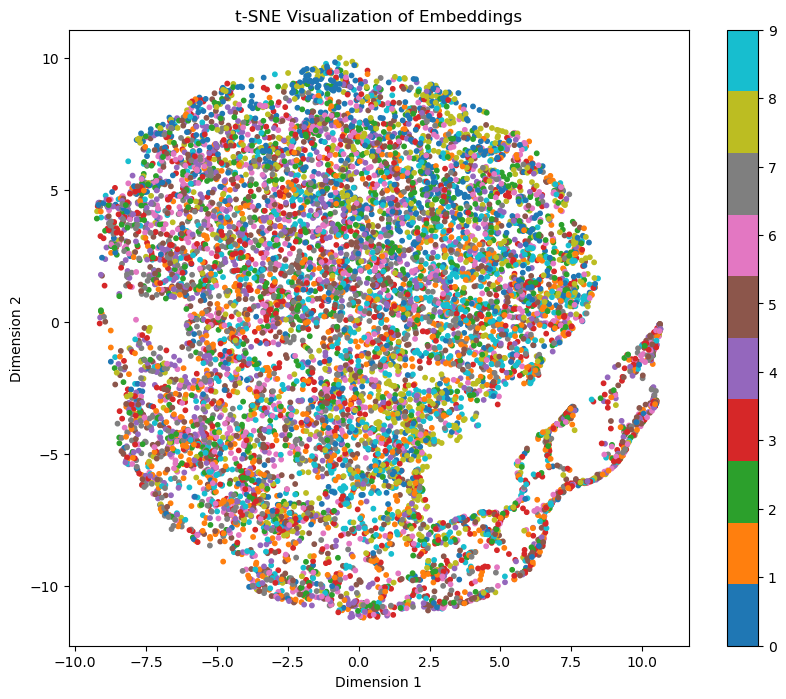

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Extract embeddings and labels from the test_loader
def extract_embeddings_and_labels(embedding_net, loader):
    embedding_net.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda() if torch.cuda.is_available() else images
            embeddings = embedding_net(images).cpu().numpy()  # Get embeddings and convert to numpy
            all_embeddings.append(embeddings)
            all_labels.append(labels.cpu().numpy())  # Convert labels to numpy

    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_embeddings, all_labels

# Function to plot the embeddings
def visualize_embeddings(embeddings, labels):
    # Apply t-SNE to reduce embeddings to 2D
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot the embeddings in 2D space with class labels as colors
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Main part - Extract embeddings, labels and visualize
embeddings, labels = extract_embeddings_and_labels(embedding_net, test_loader)
visualize_embeddings(embeddings, labels)


In [37]:
# Define transformations and load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split CIFAR-10 dataset into 5 subsets, each containing 2 classes
class_indices = {i: np.where(np.array(train_dataset.targets) == i)[0] for i in range(10)}

# Create 5 subsets: classes (0,1), (2,3), (4,5), (6,7), (8,9)
subsets_train = []
subsets_test = []
for i in range(0, 10, 2):
    train_indices = np.concatenate([class_indices[i], class_indices[i+1]])
    test_indices = np.concatenate([np.where(np.array(test_dataset.targets) == i)[0], np.where(np.array(test_dataset.targets) == i+1)[0]])
    
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    test_subset = torch.utils.data.Subset(test_dataset, test_indices)
    
    subsets_train.append(train_subset)
    subsets_test.append(test_subset)

# Create DataLoader for incremental training
def get_dataloader(subset, batch_size=32):
    return DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [38]:
# Initialize the model
from torchvision.models import googlenet, GoogLeNet_Weights
import torch.optim as optim
import torch.nn as nn

weights = GoogLeNet_Weights.DEFAULT
model = googlenet(weights=weights)
model.fc = nn.Linear(1024, 10)  # Adjust output layer for 10 classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to evaluate the model on a test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Incremental training function
def incremental_training(model, subsets_train, subsets_test, num_epochs=10):
    for increment, (train_subset, test_subset) in enumerate(zip(subsets_train, subsets_test), start=1):
        print(f"Training on Increment {increment} (Classes {2*(increment-1)} and {2*(increment-1)+1})")
        
        train_loader = get_dataloader(train_subset)
        test_loader = get_dataloader(torch.utils.data.ConcatDataset(subsets_test[:increment]))  # Test on all seen classes so far

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")
        
        # Evaluate after each increment
        accuracy = evaluate_model(model, test_loader)
        print(f"Increment {increment} Test Accuracy: {accuracy:.2f}%")

# Call the incremental training
incremental_training(model, subsets_train, subsets_test, num_epochs=10)


Training on Increment 1 (Classes 0 and 1)
Epoch 1/10, Loss: 0.1187
Epoch 2/10, Loss: 0.0675
Epoch 3/10, Loss: 0.0499
Epoch 4/10, Loss: 0.0375
Epoch 5/10, Loss: 0.0431
Epoch 6/10, Loss: 0.0349
Epoch 7/10, Loss: 0.0201
Epoch 8/10, Loss: 0.0305
Epoch 9/10, Loss: 0.0238
Epoch 10/10, Loss: 0.0228
Increment 1 Test Accuracy: 98.95%
Training on Increment 2 (Classes 2 and 3)
Epoch 1/10, Loss: 0.7170
Epoch 2/10, Loss: 0.3425
Epoch 3/10, Loss: 0.2606
Epoch 4/10, Loss: 0.2168
Epoch 5/10, Loss: 0.1725
Epoch 6/10, Loss: 0.1489
Epoch 7/10, Loss: 0.1177
Epoch 8/10, Loss: 0.1050
Epoch 9/10, Loss: 0.0966
Epoch 10/10, Loss: 0.0690
Increment 2 Test Accuracy: 44.62%
Training on Increment 3 (Classes 4 and 5)
Epoch 1/10, Loss: 0.8470
Epoch 2/10, Loss: 0.2848
Epoch 3/10, Loss: 0.2085
Epoch 4/10, Loss: 0.1633
Epoch 5/10, Loss: 0.1359
Epoch 6/10, Loss: 0.1135
Epoch 7/10, Loss: 0.0922
Epoch 8/10, Loss: 0.0752
Epoch 9/10, Loss: 0.0685
Epoch 10/10, Loss: 0.0530
Increment 3 Test Accuracy: 31.03%
Training on Increme